<a href="https://colab.research.google.com/github/christopher-ell/Deep_Learning_Begin/blob/master/2_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://www.tensorflow.org/tutorials/keras/basic_text_classification

**Summary**

1. Import data: Movie reviews as indexes
2. extract the data into 4 groups by training and test and data and labels
3. Download dictionary that takes words and translates into indexes and reverse, so it takes indexes and outputs
    words in new dictionary
4. Use the new reverse dictionary to view some of the actual words of the review

Prepare Data
5. Pad data so that all reviews are same length and can be put into a matrix together

Model
6. Structure the model making sure to add an embedding layer to translate the indexes into dense vectors of a fixed size. Add global pooling layer to get fixed size output and finally add the dense layers with parameters
7. Compile the model telling it how to optimise its parameters and the gradient descent method
8. Take a validation dataset from the training data to be used during training
9. Train the model feeding input data and labels, specifying epochs and batch size as well as validation data to be used during training
10. Evaluate new model on test data
11. Plot validation and training data by epoch for model evaluation purposes.


In [0]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.12.0


**Download IMDB Dataset**

In [0]:
## Dataset of 25,000 movie reviews from IMDB, labeled by sentiment 
## (positive/negative) 
## Each review is encoded as a sequence of word indexes, with each word encoded 
## by it's frequency, so 3 is the 3rd most frequently used word. This allows
## unpopular words to be filtered out.
imdb = keras.datasets.imdb

## Load test data and training data sets of movie reviews and labels 
## only include words in the reviews that are up to the 10,000 most used 
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


In [0]:
## Print the number of reviews and labels for reviews in the training sets
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [0]:
## Print the first review in index form
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [0]:
## Print the length of the first and second reviews
len(train_data[0]), len(train_data[1])

(218, 189)

Convert Integers Back to Words



In [0]:
# A dictinary mapping words to an integer index
## Dictionar which uses the word as a look up and gives the associated index
## Cannot yet be used to convert our index into words because it uses words
## to look up rather than indexes
word_index = imdb.get_word_index()

# The first indicies are reserved
## Insert 4 new entries into the dictionary by recreating the dictionary with
## the index of every value increased by 3 (k:(v+3)).
## As a result values 0-3 are empty and new values can be insirted into them
word_index = {k:(v + 3) for k, v in word_index.items()}
## Insert new entries for text into values 0-3
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

## Create a new dictionary that works in reverse to the old one taking in a 
## word index and outputing a word
## Iterate through each item in the original dictionary and put the key as
## the value and value as the key in the new dictionary
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

## Loop through each integer index in the text translate it into a word and
## attach it to the string.
def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


In [0]:
## Decode the first review so it can be seen in English
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

**Prepare The Data**



In [0]:
## Since each review is a different length they are padded so that they are all 
## the same so that we can put the reviews together in a matrix of 
## maxlen * number_of_reviews
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index["<PAD>"],
                                                       padding="post",
                                                       maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index["<PAD>"],
                                                      padding="post",
                                                      maxlen=256)

In [0]:
## Output the length of the first two reviews to ensure they were properly 
## padded
len(train_data[0]), len(train_data[1])

(256, 256)

In [0]:
## Print the first padded review
## The padding is carried out by 0's because <pad> is 0 in the dictionary
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

**Build The Model**

In [0]:
# Input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

## Create a neural network by stacking layers
model = keras.Sequential()
## Embedding turns positive integers (indexes) into dense vectors of a fixed 
## size.
## Here the dense vectors are size 16
## Can only take place at the first layer of a model
## Vectors learned as model trains
model.add(keras.layers.Embedding(vocab_size, 16))
## Transforms input into a fixed output vector by averaging over the sequence 
## dimensions
model.add(keras.layers.GlobalAveragePooling1D())
## Fully connected dense layer with 16 nodes, trainable parameters 
## and a non-linear relu activation function at the end
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
## Fully connected dense layer with 1 node, trainable paramter and a non-linear
## sigmoid function
# Returns number between 0-1 with probablyity negative or positive
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

## Summary of model layers, nodes and parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [0]:
## Specifies to the model how to optimize the parameters
              ## optimizer is how the model is updated at each iteration
model.compile(optimizer = tf.train.AdamOptimizer(),
              ## Loss is how the losses are summaed from across all training
              ## examples. 
              ## The optimizer will try to minimize this by changing parameters
             loss = 'binary_crossentropy',
              ## How the training and testing steps will be monitored. Here it 
              ## is accuracy which is the fraction of corectly identified images
             metrics = ['accuracy'])

**Create a Validation Set**

In [0]:
## When training we want to check the accuracy on data it hasn't yet seen so 
## we create a validation set, setting aside 10,000 examples from the training 
## set

## Slice data from the first example to the 10,000th 
x_val = train_data[:10000]
## The remaining training data after removing the first 10,000 examples
partial_x_train = train_data[10000:]

## Slice data from the first example to the 10,000th 
y_val = train_labels[:10000]
## The remaining training data after removing the first 10,000 examples
partial_y_train = train_labels[10000:]

**Train The Model**

In [0]:
## Train the model over 40 epochs in minibatches of 512. While training monitor
## the models loss accuracy on the validation sets 10,000 examples
history = model.fit(partial_x_train,
                   partial_y_train,
                    ## One epoch is the entire dataset passed forward and
                    ## backwards through the neural network once
                    ## Since we are using an iterative process like gradient 
                    ## descent we need to pass the data through multiple times
                   epochs = 40,
                    ## Since you can't pass the entire dataset through the 
                    ## network at once you divide it into batches and pass them
                    ## through at once
                   batch_size = 512,
                    ## Run the model on the validation dataset 
                   validation_data = (x_val, y_val),
                    ## Output the results of the validation dataset.
                   verbose = 1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 2s 108us/step - loss: 0.6915 - acc: 0.6150 - val_loss: 0.6892 - val_acc: 0.6767
Epoch 2/40
15000/15000 [==============================] - 1s 63us/step - loss: 0.6851 - acc: 0.7291 - val_loss: 0.6805 - val_acc: 0.7216
Epoch 3/40
15000/15000 [==============================] - 1s 63us/step - loss: 0.6720 - acc: 0.7612 - val_loss: 0.6645 - val_acc: 0.7572
Epoch 4/40
15000/15000 [==============================] - 1s 63us/step - loss: 0.6500 - acc: 0.7663 - val_loss: 0.6405 - val_acc: 0.7751
Epoch 5/40
15000/15000 [==============================] - 1s 64us/step - loss: 0.6186 - acc: 0.7964 - val_loss: 0.6070 - val_acc: 0.7866
Epoch 6/40
15000/15000 [==============================] - 1s 63us/step - loss: 0.5791 - acc: 0.8113 - val_loss: 0.5686 - val_acc: 0.7986
Epoch 7/40
15000/15000 [==============================] - 1s 63us/step - loss: 0.5346 - acc: 0.8291 - val_loss: 0.5276 - val_ac

**Evaluate The Model**

In [0]:
## Returns the loss values and metric values for the model in test mode on the 
## provided test datasets 
results = model.evaluate(test_data, test_labels)

## print results
print(results)

25000/25000 [==============================] - 1s 39us/step
[0.32326120984077455, 0.8728]


**Create a Graph of Accuracy and Loss Over Time**

In [0]:
## model.fit() contains a dictionary with everything that happened during 
## training
history_dict = history.history
## There are four keys in the dictionary, one for each monitored metric during 
## training and evaluation
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

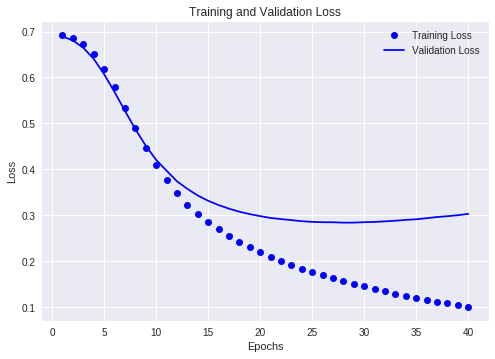

In [0]:
## Plot the metrics that were recorded during training for comparison
## as well as training and validation accuracy

import matplotlib.pyplot as plt

## extract accuracy history of data during training
acc = history.history['acc']
## Extract validation accuracy of data during training
val_acc = history.history['val_acc']
## Extract loss history of data during training
loss = history.history['loss']
## Extract validation losses of data during training
val_loss = history.history['val_loss']

## Calculate how many epochs there were by looking at length of accuracy data
epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
## Plot epochs vs loss using blue dots ("bo") and label it Training Loss
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
# b is for "solid blue line"
## Plot epochs vs val_loss using blue line ("b") and label it validation loss
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
## Title the graph "Training and Validation Loss"
plt.title('Training and Validation Loss')
## x label is "Epochs"
plt.xlabel('Epochs')
## y label is "Loss"
plt.ylabel('Loss')
## Add legend
plt.legend()

## Show the graph
plt.show()

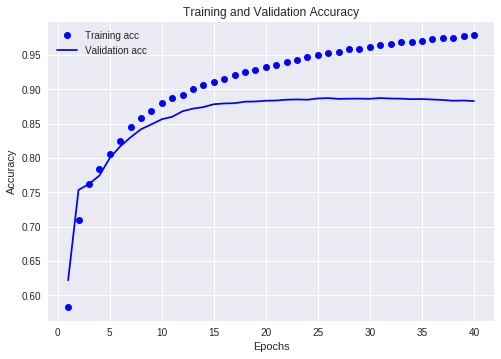

In [0]:
# Plot accuracy rather than loss

plt.clf()   #clear figure
## Extract the accuracy data from the dictionary
acc_values = history_dict['acc']
## Extract the validation accuracy data from the dictionary
val_acc_values = history_dict['val_acc']

## Plot epochs vs accuracy in blue dots "bo" labeled "Training acc"
plt.plot(epochs, acc, 'bo', label = 'Training acc')
## Plot epoch vs validation accuracy in blue line "b" labelled "Validation acc"
plt.plot(epochs, val_acc, 'b', label = "Validation acc")
## Title the graph "Training and Validation Accuracy"
plt.title('Training and Validation Accuracy')
## Label the x-acis "Epochs"
plt.xlabel('Epochs')
## Label the y-axis "Accuracy"
plt.ylabel('Accuracy')
## Add a legend
plt.legend()

## Show the graph
plt.show()